# Cleaning the data
Question in mind - Can we accurately predict how much tips a driver will get based on pick-up location, the distance traveled to destination and time spent?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.path as mplPath
import rtree
import fiona.crs
import geopandas as gpd
import pyproj
import shapely.geometry as geom
%matplotlib inline

In [2]:
january2013=pd.read_csv("datasets/yellow_tripdata_2013-01.csv")

Filter the data to only include coordinates within New York and drop the colums we don't need
such as the vendor_id. Remove bad passenger counts, you can't get tipped with 0 passengers nor can a taxi have 255 people at one time

In [3]:
january2013 = january2013.loc[(january2013['pickup_longitude'] > -74.06) & (january2013['pickup_longitude'] < -73.77) & (january2013['pickup_latitude'] > 40.61) &  (january2013['pickup_latitude'] < 40.91)]
january2013 = january2013.loc[(january2013['passenger_count'] > 0) & (january2013['passenger_count'] < 7)]
january2013 = january2013.reset_index()
january2013 = january2013.drop('index', 1)
january2013 = january2013.drop('vendor_id',1)
january2013 = january2013.drop('rate_code',1)
january2013 = january2013.drop('store_and_fwd_flag',1)
january2013 = january2013.drop('fare_amount',1)
january2013 = january2013.drop('surcharge',1)
january2013 = january2013.drop('mta_tax',1)
january2013 = january2013.drop('tolls_amount',1)

In [4]:
print(january2013.shape)
january2013.head()

(14496449, 11)


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount
0,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,-73.989840,40.751173,CSH,0.0,7.0
1,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,-73.994499,40.750659,CSH,0.0,7.0
2,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,-74.009831,40.726000,CSH,0.0,7.0
3,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,-73.984737,40.759388,CSH,0.0,6.0
4,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,-74.002583,40.747867,CSH,0.0,10.5


Code to convert longitude/latitude to block id, might be useful later, we'll see

In [5]:
def indexZones(shapeFilename):
    index = rtree.Rtree()
    zones = gpd.read_file(shapeFilename).to_crs(fiona.crs.from_epsg(2263))
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

In [6]:
def findBlock(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        z = mplPath.Path(np.array(zones.geometry[idx].exterior))
        if z.contains_point(np.array(p)):
            return zones['OBJECTID'][idx]
    return -1

In [7]:
def mapToZone(parts):
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = indexZones('datasets/block-groups-polygons.geojson')
    for line in parts:
        if (line['pickup_longitude'] and line['pickup_latitude']):
            pickup_location  = geom.Point(proj(float(line['pickup_longitude']), float(line['pickup_latitude'])))
            pickup_block = findBlock(pickup_location, index, zones)
            if pickup_block >= 0:
                print (pickup_block)
                
#mapToZone(data_pd.head(20).T.to_dict().values())

Looking at the time value, we find the day of the week, time spent to reach destination, and hour. We will insert all of these as new columns.

From datetime of pick-up we'll be breaking it down into month, day, day of the week, time in minutes

In [8]:
def add_data(df):
    df_timestamp = pd.to_datetime(pd.Series(df['pickup_datetime']))
    df['trip_distance']*0.621371
    df['weekday'] = df_timestamp.dt.dayofweek
    df['month'] = df_timestamp.dt.month
    df['hour'] = df_timestamp.dt.hour
    df['day'] = df_timestamp.dt.day
    df['minutes'] = (df_timestamp.dt.hour)*60 + df_timestamp.dt.minute
    time_spent = pd.to_datetime(df['dropoff_datetime']) - pd.to_datetime(df['pickup_datetime'])
    df['time_spent'] = pd.to_datetime(time_spent).dt.minute
    return df

In [9]:
january2013 = add_data(january2013)

In [10]:
january2013.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount,weekday,month,hour,day,minutes,time_spent
0,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,-73.989840,40.751173,CSH,0.0,7.0,1,1,15,1,911,6
1,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,-73.994499,40.750659,CSH,0.0,7.0,6,1,0,6,18,4
2,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,-74.009831,40.726000,CSH,0.0,7.0,5,1,18,5,1129,4
3,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,-73.984737,40.759388,CSH,0.0,6.0,0,1,23,7,1434,4
4,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,-74.002583,40.747867,CSH,0.0,10.5,0,1,23,7,1405,9


Does payment type affect the tips?

"CRD" -- card, debit or credit

"CSH" -- cash

"DIS" -- disputed fare 

"NOC" -- no charge

"UNK" -- unknown

In [11]:
print(january2013.payment_type.unique()) #the types of payment

['CSH' 'CRD' 'DIS' 'NOC' 'UNK']


payment_type
CRD    7596889
CSH    6851480
DIS      10890
NOC      31923
UNK       5267
dtype: int64
Axes(0.125,0.125;0.775x0.775)


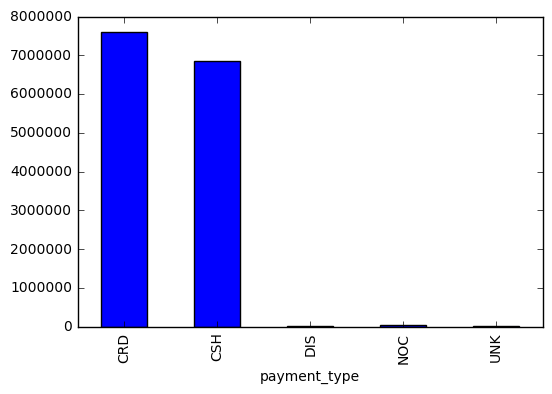

In [12]:
paymentandtips = january2013.groupby('payment_type')
print(paymentandtips.size())
print(paymentandtips.size().plot(kind='bar'))

payment_type
CRD    2.404894
CSH    0.000686
DIS    0.013596
NOC    0.013544
UNK    3.177655
Name: tip_amount, dtype: float64
Axes(0.125,0.125;0.775x0.775)


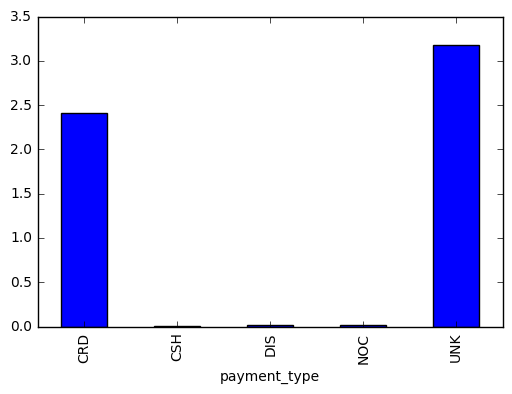

In [13]:
print(paymentandtips.tip_amount.mean())
print(paymentandtips.tip_amount.mean().plot(kind='bar'))

The highest two payment types are crd and csh but the crd and unk are the payment types with the highest average types, probably wouldn't be interesting to explore since unk is a very uncommon payment type, so let's look at the tip percentage which it 

(tip)/(total cost)*100

which is the average tips a person gives in relation to the total cost of the ride

In [14]:
avgtips = (january2013.tip_amount/january2013.total_amount)*100
january2013['avg_tip'] = avgtips
january2013.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount,weekday,month,hour,day,minutes,time_spent,avg_tip
0,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,-73.989840,40.751173,CSH,0.0,7.0,1,1,15,1,911,6,0.0
1,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,-73.994499,40.750659,CSH,0.0,7.0,6,1,0,6,18,4,0.0
2,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,-74.009831,40.726000,CSH,0.0,7.0,5,1,18,5,1129,4,0.0
3,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,-73.984737,40.759388,CSH,0.0,6.0,0,1,23,7,1434,4,0.0
4,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,-74.002583,40.747867,CSH,0.0,10.5,0,1,23,7,1405,9,0.0


Create a new data set that only includes where tips > 0.0

In [15]:
january2013_remove_non_tips = january2013.loc[(january2013['tip_amount'] > 0.0)]
january2013_remove_non_tips = january2013_remove_non_tips.reset_index()
january2013_remove_non_tips = january2013_remove_non_tips.drop('index', 1)
january2013_remove_non_tips.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount,weekday,month,hour,day,minutes,time_spent,avg_tip
0,2013-01-13 10:27:00,2013-01-13 10:35:00,1,2.92,-73.992190,40.723945,-73.966325,40.715732,CRD,2.75,14.25,6,1,10,13,627,8,19.298246
1,2013-01-13 10:27:00,2013-01-13 10:36:00,1,3.93,-73.982380,40.731427,-73.947020,40.779875,CRD,2.40,14.90,6,1,10,13,627,9,16.107383
2,2013-01-13 10:29:00,2013-01-13 10:39:00,3,4.51,-73.957385,40.777180,-73.975322,40.729242,CRD,2.90,17.90,6,1,10,13,629,10,16.201117
3,2013-01-13 10:25:00,2013-01-13 10:32:00,6,1.84,-74.008250,40.705572,-74.013047,40.716052,CRD,1.70,10.70,6,1,10,13,625,7,15.887850
4,2013-01-13 10:02:00,2013-01-13 10:38:00,1,20.78,-73.788310,40.641513,-73.975515,40.792112,CRD,7.70,65.00,6,1,10,13,602,36,11.846154


Does passenger count have any correlation to amount of tips given?

passenger_count
1    10266280
2     1952890
3      586388
4      276135
5      904010
6      510746
dtype: int64
passenger_count
1    1.281788
2    1.233192
3    1.121359
4    1.036398
5    1.261450
6    1.253359
Name: tip_amount, dtype: float64
Axes(0.125,0.125;0.775x0.775)


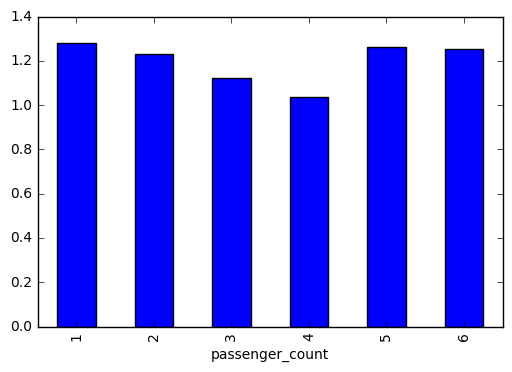

In [16]:
peopleandtips = january2013.groupby('passenger_count')
print(peopleandtips.size())
print(peopleandtips.tip_amount.mean())
print(peopleandtips.tip_amount.mean().plot(kind='bar'))

Looking at the graph above which is the average tip based on passenger with those passengers who don't tip, they seem to pay about the same. While looking at the bottom graph without passengers who don't pay tips, the graph is about the same, so passenger_count is irrelevant

passenger_count
1    5351644
2     940240
3     267166
4     113288
5     464750
6     263360
dtype: int64
passenger_count
1    2.458906
2    2.561355
3    2.461210
4    2.526179
5    2.453713
6    2.430697
Name: tip_amount, dtype: float64
Axes(0.125,0.125;0.775x0.775)


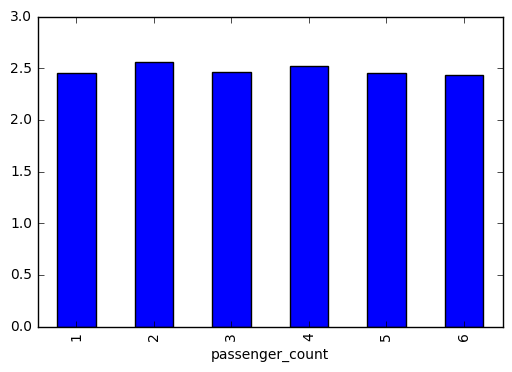

In [17]:
peopleandtips = january2013_remove_non_tips.groupby('passenger_count')
print(peopleandtips.size())
print(peopleandtips.tip_amount.mean())
print(peopleandtips.tip_amount.mean().plot(kind='bar'))

In [18]:
january2013 = january2013.drop('passenger_count',1)
january2013_remove_non_tips = january2013_remove_non_tips.drop('passenger_count',1)
january2013.head()

,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount,weekday,month,hour,day,minutes,time_spent,avg_tip
0,2013-01-01 15:11:48,2013-01-01 15:18:10,1.0,-73.978165,40.757977,-73.989840,40.751173,CSH,0.0,7.0,1,1,15,1,911,6,0.0
1,2013-01-06 00:18:35,2013-01-06 00:22:54,1.5,-74.006680,40.731781,-73.994499,40.750659,CSH,0.0,7.0,6,1,0,6,18,4,0.0
2,2013-01-05 18:49:41,2013-01-05 18:54:23,1.1,-74.004711,40.737770,-74.009831,40.726000,CSH,0.0,7.0,5,1,18,5,1129,4,0.0
3,2013-01-07 23:54:15,2013-01-07 23:58:20,0.7,-73.974600,40.759945,-73.984737,40.759388,CSH,0.0,6.0,0,1,23,7,1434,4,0.0
4,2013-01-07 23:25:03,2013-01-07 23:34:24,2.1,-73.976252,40.748528,-74.002583,40.747867,CSH,0.0,10.5,0,1,23,7,1405,9,0.0


Let's look at Distance Traveled (km) and Tip Percentage (Frequency of tips)

In [19]:
#january2013_remove_non_tips.plot(x='trip_distance',y='avg_tip',style=['o','rx'])

Can we estimate how much tips a taxi driver will be given based on the day of the week, the hour they were picked up, the location they picked up, how much time they spent in the taxi and how far they went?

In [20]:
january2013['pickup'] = january2013['pickup_latitude'].map(str) +','+january2013['pickup_longitude'].map(str)
january2013.head() #we merge the pickup lat and long for each row so we can group by pickup location

,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount,weekday,month,hour,day,minutes,time_spent,avg_tip,pickup
0,2013-01-01 15:11:48,2013-01-01 15:18:10,1.0,-73.978165,40.757977,-73.989840,40.751173,CSH,0.0,7.0,1,1,15,1,911,6,0.0,"40.757977,-73.978165"
1,2013-01-06 00:18:35,2013-01-06 00:22:54,1.5,-74.006680,40.731781,-73.994499,40.750659,CSH,0.0,7.0,6,1,0,6,18,4,0.0,"40.731781,-74.00668"
2,2013-01-05 18:49:41,2013-01-05 18:54:23,1.1,-74.004711,40.737770,-74.009831,40.726000,CSH,0.0,7.0,5,1,18,5,1129,4,0.0,"40.73777,-74.004711"
3,2013-01-07 23:54:15,2013-01-07 23:58:20,0.7,-73.974600,40.759945,-73.984737,40.759388,CSH,0.0,6.0,0,1,23,7,1434,4,0.0,"40.759945,-73.97459999999998"
4,2013-01-07 23:25:03,2013-01-07 23:34:24,2.1,-73.976252,40.748528,-74.002583,40.747867,CSH,0.0,10.5,0,1,23,7,1405,9,0.0,"40.748528,-73.976252"


In [30]:
bayesJanuary = january2013[['pickup_longitude','pickup_latitude','trip_distance','weekday','pickup','hour','time_spent','tip_amount']]
print(bayesJanuary.shape)
bayesJanuary.head()

(14496449, 8)


,pickup_longitude,pickup_latitude,trip_distance,weekday,pickup,hour,time_spent,tip_amount
0,-73.978165,40.757977,1.0,1,"40.757977,-73.978165",15,6,0.0
1,-74.006680,40.731781,1.5,6,"40.731781,-74.00668",0,4,0.0
2,-74.004711,40.737770,1.1,5,"40.73777,-74.004711",18,4,0.0
3,-73.974600,40.759945,0.7,0,"40.759945,-73.97459999999998",23,4,0.0
4,-73.976252,40.748528,2.1,0,"40.748528,-73.976252",23,9,0.0


Break it into steps

If we just look at the day of the week they were picked up, how much would a taxi driver be given?

weekday
0    1654512
1    2280963
2    2308985
3    2458213
4    2040735
5    2011008
6    1742033
dtype: int64
Axes(0.125,0.125;0.775x0.775)


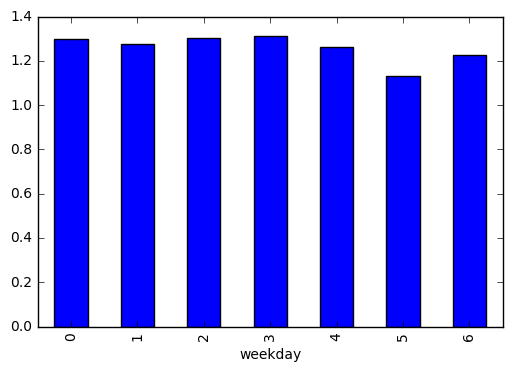

In [31]:
print(bayesJanuary.groupby('weekday').size())
print(bayesJanuary.groupby('weekday').tip_amount.mean().plot(kind='bar'))

If we just look at the day of the week they were picked up and the hour they were picked up, how much would a taxi driver be given?

weekday  hour
0        0        39169
         1        25772
         2        17050
         3        12102
         4        11679
         5        16689
         6        41235
         7        74002
         8        94685
         9        92086
         10       79218
         11       77407
         12       83759
         13       82990
         14       90913
         15       91782
         16       79817
         17       94034
         18      114230
         19      109153
         20       95579
         21       88863
         22       84082
         23       58216
1        0        64842
         1        52890
         2        42314
         3        33887
         4        26648
         5        26703
                  ...  
5        18      119556
         19      127679
         20      115315
         21      111193
         22      124902
         23      131815
6        0       125253
         1       111428
         2        95112
         3        73022
  

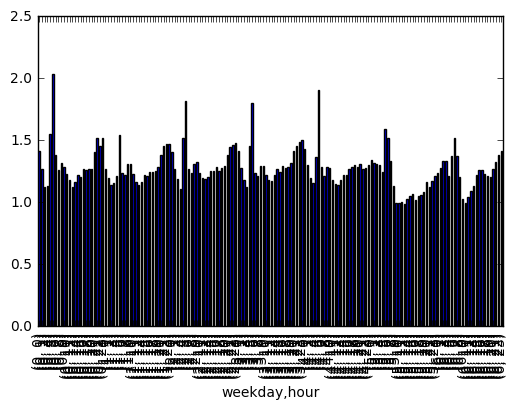

In [32]:
print(bayesJanuary.groupby(['weekday','hour']).size())
print(bayesJanuary.groupby(['weekday','hour']).tip_amount.mean().plot(kind='bar'))

Let's look into one day of the week to understand what's going on...

In [33]:
bayesJanuarymonday = bayesJanuary.loc[(bayesJanuary['weekday'] == 0)]
print(bayesJanuarymonday.shape)
bayesJanuarymonday.head()

(1654512, 8)


,pickup_longitude,pickup_latitude,trip_distance,weekday,pickup,hour,time_spent,tip_amount
3,-73.974600,40.759945,0.7,0,"40.759945,-73.97459999999998",23,4,0.0
4,-73.976252,40.748528,2.1,0,"40.748528,-73.976252",23,9,0.0
5,-73.966743,40.764252,1.7,0,"40.764252,-73.96674299999998",15,10,0.0
7,-73.989937,40.756773,10.7,0,"40.756773,-73.989937",12,31,0.0
8,-73.980071,40.743138,0.8,0,"40.743138,-73.98007099999998",18,5,0.0


hour
0      39169
1      25772
2      17050
3      12102
4      11679
5      16689
6      41235
7      74002
8      94685
9      92086
10     79218
11     77407
12     83759
13     82990
14     90913
15     91782
16     79817
17     94034
18    114230
19    109153
20     95579
21     88863
22     84082
23     58216
dtype: int64
Axes(0.125,0.125;0.775x0.775)


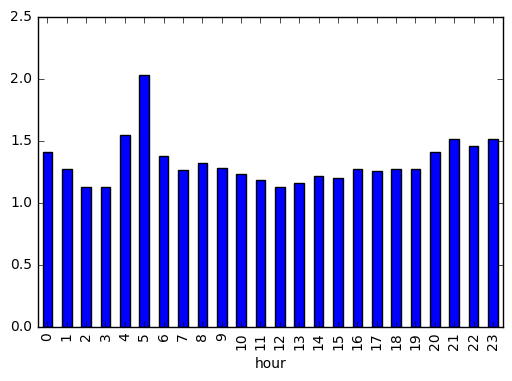

In [34]:
print(bayesJanuarymonday.groupby('hour').size())
print(bayesJanuarymonday.groupby('hour').tip_amount.mean().plot(kind='bar'))

So for each hour we can see the average tips, so at 5am an taxi driver can get the highest tips overall. What if we look into each location at 5am?

In [93]:
bayesJanuarymonday5am = bayesJanuarymonday.loc[(bayesJanuarymonday['hour'] == 5)]
print(bayesJanuarymonday5am.shape)
bayesJanuarymonday5am.head()

(16689, 8)


,pickup_longitude,pickup_latitude,trip_distance,weekday,pickup,hour,time_spent,tip_amount
130545,-73.978370,40.729637,0.78,0,"40.729637,-73.97837",5,2,0.0
130546,-73.994185,40.741147,1.28,0,"40.741147,-73.994185",5,5,1.0
130547,-73.967368,40.763040,0.71,0,"40.76304,-73.96736799999998",5,4,0.0
130548,-73.977662,40.752397,0.99,0,"40.752397,-73.97766199999998",5,4,1.8
130549,-73.986625,40.746063,16.76,0,"40.746063,-73.986625",5,32,0.0


In [94]:
#print(bayesJanuarymonday5am.groupby('pickup').size())
averagetipsperlocation = bayesJanuarymonday5am.groupby('pickup').tip_amount.mean()
averagetimeperlocation = bayesJanuarymonday5am.groupby('pickup').time_spent.mean()
averagedistancesperlocation = bayesJanuarymonday5am.groupby('pickup').trip_distance.mean()
avg_tip_loc_array = []
avg_time_loc_array = []
avg_distance_loc_array = []
for data in averagetipsperlocation:
    avg_tip_loc_array.append(data)
for data in averagetimeperlocation:
    avg_time_loc_array.append(data)
for data in averagedistancesperlocation:
    avg_distance_loc_array.append(data)

In [95]:
bayesJanuarymonday5am = bayesJanuarymonday5am.drop_duplicates('pickup')
bayesJanuarymonday5am['avg_tip'] = avg_tip_loc_array
bayesJanuarymonday5am['avg_time_spent'] = avg_time_loc_array
bayesJanuarymonday5am['avg_distance'] = avg_distance_loc_array
bayesJanuarymonday5am.head()

,pickup_longitude,pickup_latitude,trip_distance,weekday,pickup,hour,time_spent,tip_amount,avg_tip,avg_time_spent,avg_distance
130545,-73.978370,40.729637,0.78,0,"40.729637,-73.97837",5,2,0.0,18.9,38.0,21.66
130546,-73.994185,40.741147,1.28,0,"40.741147,-73.994185",5,5,1.0,17.7,33.0,21.65
130547,-73.967368,40.763040,0.71,0,"40.76304,-73.96736799999998",5,4,0.0,0.0,0.0,0.00
130548,-73.977662,40.752397,0.99,0,"40.752397,-73.97766199999998",5,4,1.8,5.0,29.0,19.58
130549,-73.986625,40.746063,16.76,0,"40.746063,-73.986625",5,32,0.0,0.0,3.0,1.00


In [96]:
bayesJanuarymonday5am_remove_non_tips = bayesJanuarymonday5am.loc[(bayesJanuarymonday5am['avg_tip'] > 0.0)]
bayesJanuarymonday5am_remove_non_tips.head()

,pickup_longitude,pickup_latitude,trip_distance,weekday,pickup,hour,time_spent,tip_amount,avg_tip,avg_time_spent,avg_distance
130545,-73.978370,40.729637,0.78,0,"40.729637,-73.97837",5,2,0.0,18.90,38.0,21.660
130546,-73.994185,40.741147,1.28,0,"40.741147,-73.994185",5,5,1.0,17.70,33.0,21.650
130548,-73.977662,40.752397,0.99,0,"40.752397,-73.97766199999998",5,4,1.8,5.00,29.0,19.580
130551,-73.990917,40.756755,1.01,0,"40.756755,-73.99091699999998",5,2,0.0,1.28,14.0,4.136
130566,-73.971895,40.794662,3.77,0,"40.794662,-73.971895",5,10,2.6,3.70,2.0,0.000


In [97]:
bayesJanuarymonday5am.shape, bayesJanuarymonday5am_remove_non_tips.shape

((16598, 11), (8423, 11))

We now know the average tips given to a taxi driver based on day of the week and the hour the customer was picked up for each location at 5 am in the morning on a Monday